In [ ]:
# Copyright (C) 2024  Jose Ángel Pérez Garrido
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Image-to-image translation

This project demonstrates how to build and train a conditional generative adversarial network (cGAN) called pix2pix that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In this example, the network will generate images of urban scenes using the [TU-Graz](http://cmp.felk.cvut.cz/~tylecr1/facade/) dataset provided by the [Institute of Computer Graphics and Vision](https://www.tugraz.at/index.php?id=22387).

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of the network will contain:

- A generator with a [U-Net](https://arxiv.org/abs/1505.04597)-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).

Part of the code is based on the [pix2pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix) from Tensorflow.

### Prepare the environment

In [3]:
# Variables
DATASET_FOLDER = "./datasets"
EVAL_FOLDER = "./eval"

GENERATOR_NAME = "attention_2" # generator type: "unet", "enc_dec", "attention_1", "attention_2"
OPTIMIZER = "adam" # optimizer: "adam", "sgd"
USE_DA = True # use data augmentation: True or False
LR = 2e-4 # learning rate
BATCH_SIZE = 10 # The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
 
SEED = 42 # Fixing the seed for PRNGs, to help reproducibility

In [4]:
import math
import os
import pathlib
import time
import datetime
import requests
import tarfile

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from IPython import display

from tqdm.auto import tqdm

from scipy.linalg import sqrtm

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras.applications.vgg16 import *
from keras.applications import InceptionV3

# Fixing the seed for PRNGs, to help reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load dataset

In [4]:
dataset_name = "TU-Graz" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"] # Datasets available in the pix2pix repository

DATASET_PATH = DATASET_FOLDER+"/"+dataset_name

In [298]:
# Download pix2pix dataset from URL
#_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

#response = requests.get(_URL, stream=True)
#with tarfile.open(fileobj=response.raw, mode="r|gz") as file:
#    file.extractall(path=DATASET_FOLDER, filter=None)

In [299]:
print(list(os.listdir(DATASET_FOLDER)))

assert dataset_name in os.listdir(DATASET_FOLDER), "Dataset not found"

['TU-Graz']


Each original image is of size `400 x 1200` containing two `400 x 600` images, a real image (left side) and its corresponding label map (right side):

In [300]:
sample_image = tf.io.read_file(str(DATASET_PATH + '/image_001.png'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(400, 1200, 3)


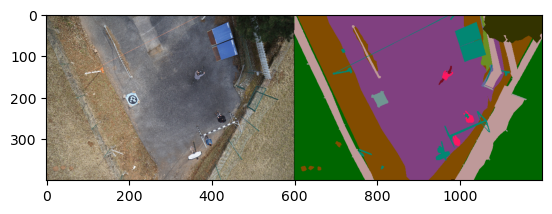

In [301]:
plt.figure()
plt.imshow(sample_image)

In [302]:
def load(image_file, type=tf.float32):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, type)
  real_image = tf.cast(real_image, type)

  return input_image, real_image

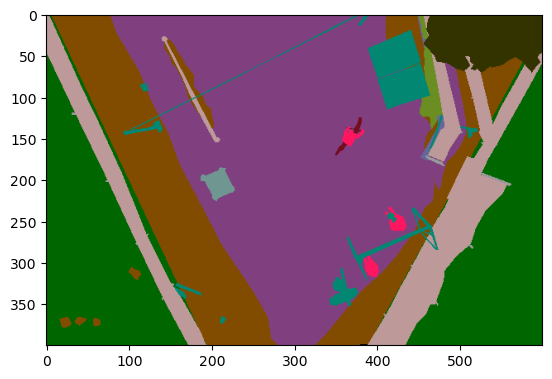

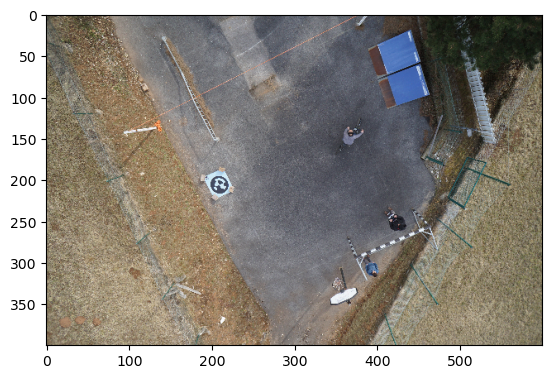

In [303]:
inp, re = load(str(DATASET_PATH + '/image_001.png'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

## Cityscapes Classes

Let us first explore what TU-Graz contains. As stated by the Institute of Computer Graphics and Vision in the [Dataset Overview](https://www.tugraz.at/index.php?id=22387), the complexity of the dataset is limited to 23 classes as listed below.

Therefore, we will use these methods to list all the classes appearing in this dataset, along with their related information:

In [5]:
class_file = pd.read_csv(str(DATASET_PATH + '/class_dict.csv'))

class_file

name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0

In [6]:
CLASSES = list(class_file["name"])
NUM_CLASSES = len(CLASSES)
COLORS = list(zip(class_file[" r"],class_file[" g"],class_file[" b"]))
COLORS_TF = tf.constant(COLORS, dtype=tf.int32) # TF constant corresponding to our color list

print(f"{CLASSES=}")
print(f"{COLORS=}")

CLASSES=['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']
COLORS=[(0, 0, 0), (128, 64, 128), (130, 76, 0), (0, 102, 0), (112, 103, 87), (28, 42, 168), (48, 41, 30), (0, 50, 89), (107, 142, 35), (70, 70, 70), (102, 102, 156), (254, 228, 12), (254, 148, 12), (190, 153, 153), (153, 153, 153), (255, 22, 96), (102, 51, 0), (9, 143, 150), (119, 11, 32), (51, 51, 0), (190, 250, 190), (112, 150, 146), (2, 135, 115), (255, 0, 0)]


2024-05-10 20:06:30.783650: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 20:06:30.807801: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 20:06:30.808042: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 20:06:30.810432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 20:06:30.810669: I external/local_xla/xla/stream_executor

### Data processing

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), we will apply random jittering and mirroring to preprocess the training set.

The procedure is defined below:

1. Resize each `400 x 600` image to a—`286 x 286`, or directly to `256 x 256` if data augmentation is not applied.
2. (With data augmentation) Randomly crop it to `256 x 256`.
3. (With data augmentation) Randomly flip the image horizontally i.e., left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range (as indicated in [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks?tab=readme-ov-file#1-normalize-the-inputs)).

In [306]:
# The training set consist of 320 images
BUFFER_SIZE = 320

# Each image must be 256x256 in size for the model input
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [307]:
def resize(image, height, width, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR):
  image = tf.image.resize(image, [height, width],
                                method=method)

  return image

In [308]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_WIDTH, IMG_HEIGHT, 3])

  return cropped_image[0], cropped_image[1]

In [309]:
# Normalizing the images to [-1, 1]
def normalize(image):
  image = (image / 127.5) - 1

  return image

In [310]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image = resize(input_image, 286, 286)
  real_image = resize(real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

Let's inspect some of the preprocessed output:

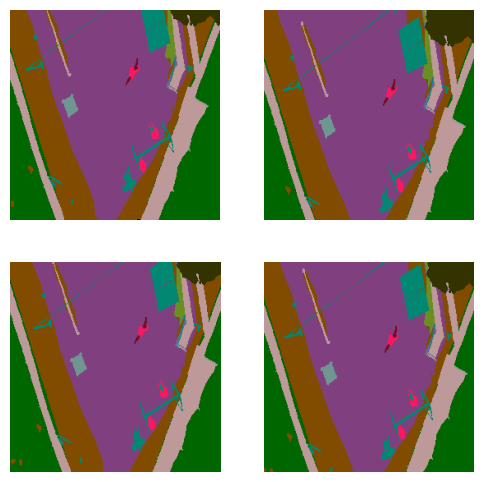

In [311]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [312]:
def load_image(image_file):
  input_image, real_image = load(image_file)
  input_image = resize(input_image,IMG_WIDTH, IMG_HEIGHT)
  real_image = resize(real_image,IMG_WIDTH, IMG_HEIGHT)
  input_image = normalize(input_image)
  real_image = normalize(real_image)

  return input_image, real_image

def load_image_da(image_file): # With data augmentation
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image = normalize(input_image)
  real_image = normalize(real_image)

  return input_image, real_image

Here we divide the dataset in 3 sets: training, validation and test. We employ an 80/10/10 split.

In [313]:
# 80% training, 10% validation, and 10% test
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

dataset = tf.data.Dataset.list_files(str(DATASET_PATH + '/*.png'), shuffle=False, seed=SEED)

# Calculate the sizes for each set
dataset_size = len(list(dataset))
train_size = int(train_percentage * dataset_size)
val_size = int(val_percentage * dataset_size)
test_size = dataset_size - train_size - val_size

In [314]:
# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

# Save datasets for future use
#tf.data.Dataset.save(train_dataset, f"{DATASET_PATH}/train_dataset")
#tf.data.Dataset.save(val_dataset, f"{DATASET_PATH}/val_dataset")
#tf.data.Dataset.save(test_dataset, f"{DATASET_PATH}/test_dataset")

train_dataset = train_dataset.map(load_image_da if USE_DA else load_image,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

print("Training dataset size:",train_dataset.cardinality().numpy())

val_dataset = val_dataset.map(load_image)
val_dataset = val_dataset.batch(BATCH_SIZE)

print("Validation dataset size:",val_dataset.cardinality().numpy())

test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

print("Test dataset size:",test_dataset.cardinality().numpy())

Training dataset size: 32
Validation dataset size: 4
Test dataset size: 4


## Build the generator

The generator of the pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](../images/segmentation.ipynb) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [315]:
OUTPUT_CHANNELS = 3

In [316]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [317]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(rj_inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


Define the upsampler (decoder):

In [318]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [319]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Define the generator with the downsampler and the upsampler:

In [320]:
def Generator_Enc_Dec(output_channels=OUTPUT_CHANNELS, activation='tanh'):
    inputs = Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 512)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 512)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 512)
        upsample(512, 4),  # (batch_size, 16, 16, 512)
        upsample(256, 4),  # (batch_size, 32, 32, 256)
        upsample(128, 4),  # (batch_size, 64, 64, 128)
        upsample(64, 4),  # (batch_size, 128, 128, 64)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(output_channels, 4, strides=2,
                            padding='same',
                            kernel_initializer=initializer,
                            activation=activation)  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    for down in down_stack:
        x = down(x)

    # Upsampling and establishing the skip connections
    for up in up_stack:
        x = up(x)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [321]:
def Generator_Unet(output_channels=OUTPUT_CHANNELS, activation='tanh'):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation=activation)  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Using attention (with transformer and self-attention blocks)

In [322]:
# Define TransformerBlock
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads=8, d_model=512, dff=2048, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.multi_head_attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class SelfAttentionBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttentionBlock, self).__init__()
        self.gamma = tf.Variable(initial_value=0., trainable=True)

    def build(self, input_shape):
        super(SelfAttentionBlock, self).build(input_shape)
        self.channels = input_shape[-1]

        self.query_conv = tf.keras.layers.Conv2D(self.channels // 8, 1, padding='same')
        self.key_conv = tf.keras.layers.Conv2D(self.channels // 8, 1, padding='same')
        self.value_conv = tf.keras.layers.Conv2D(self.channels, 1, padding='same')

    def call(self, inputs):
        # Query tensor
        query = self.query_conv(inputs)
        # Key tensor
        key = self.key_conv(inputs)
        # Value tensor
        value = self.value_conv(inputs)

        # Reshape tensors for matrix multiplication
        batch_size, height, width, _ = tf.unstack(tf.shape(inputs))
        num_patches = height * width
        query = tf.reshape(query, [batch_size, num_patches, -1])
        key = tf.reshape(key, [batch_size, num_patches, -1])
        value = tf.reshape(value, [batch_size, num_patches, -1])

        # Calculate attention map
        attention_map = tf.nn.softmax(tf.matmul(query, key, transpose_b=True) / tf.sqrt(tf.cast(self.channels, tf.float32)), axis=-1)

        # Apply attention map to value tensor
        attention_out = tf.matmul(attention_map, value)

        # Reshape attention output and apply scaling factor (gamma)
        attention_out = tf.reshape(attention_out, [batch_size, height, width, -1])
        out = inputs + self.gamma * attention_out
        return out

def Generator_Attention_UNet_2(output_channels=3, activation='tanh'):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        TransformerBlock(),
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        TransformerBlock(),
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        TransformerBlock(),
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        SelfAttentionBlock(),
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        SelfAttentionBlock(),
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        SelfAttentionBlock(),
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(output_channels, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation=activation)  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        if down.__class__ is not TransformerBlock: # Avoid skips to Attention blocks
            skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for i, up in enumerate(up_stack):
        x = up(x)
        if up.__class__ is not SelfAttentionBlock: # Avoid skips to Attention blocks
            x = tf.keras.layers.Concatenate()([x, next(skips)])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Using attention (with attention gates)

In [323]:
def attention_block(F_g, F_l, F_int):
    """
    Attention block
    :param F_g: Input tensor from lower layer
    :param F_l: Input tensor from higher layer
    :param F_int: Internal number of filters of attention block
    :return: Upsampled tensor with attention
    """
    g1 = tf.keras.layers.Conv2D(F_int, kernel_size=1, strides=1, padding='same')(F_g)
    x1 = tf.keras.layers.Conv2D(F_int, kernel_size=1, strides=1, padding='same')(F_l)
    psi = tf.keras.layers.Add()([g1, x1])
    psi = tf.keras.layers.Activation('relu')(psi)
    psi = tf.keras.layers.Conv2D(1, kernel_size=1, strides=1, padding='same')(psi)
    psi = tf.keras.layers.Activation('sigmoid')(psi)
    return tf.keras.layers.Multiply()([F_l, psi])

def Generator_Attention_UNet(output_channels=3, activation='tanh'):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(output_channels, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation=activation)  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections with attention gates
    for up, skip in zip(up_stack, skips):
        x = up(x)
        F_int = x.shape[3]
        att = attention_block(skip, x, F_int)
        x = tf.keras.layers.Concatenate()([x, att])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architectures:

```python
generator = Generator_Enc_Dec()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
```

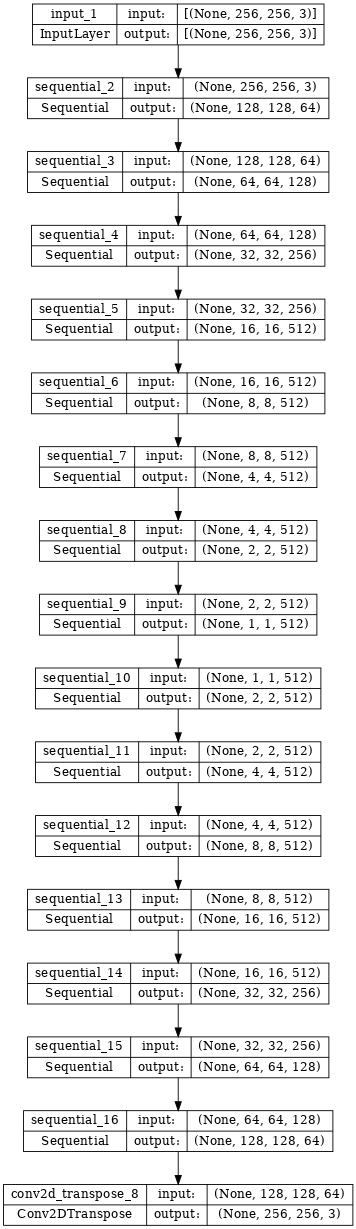

```python
generator = Generator_Unet()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
```

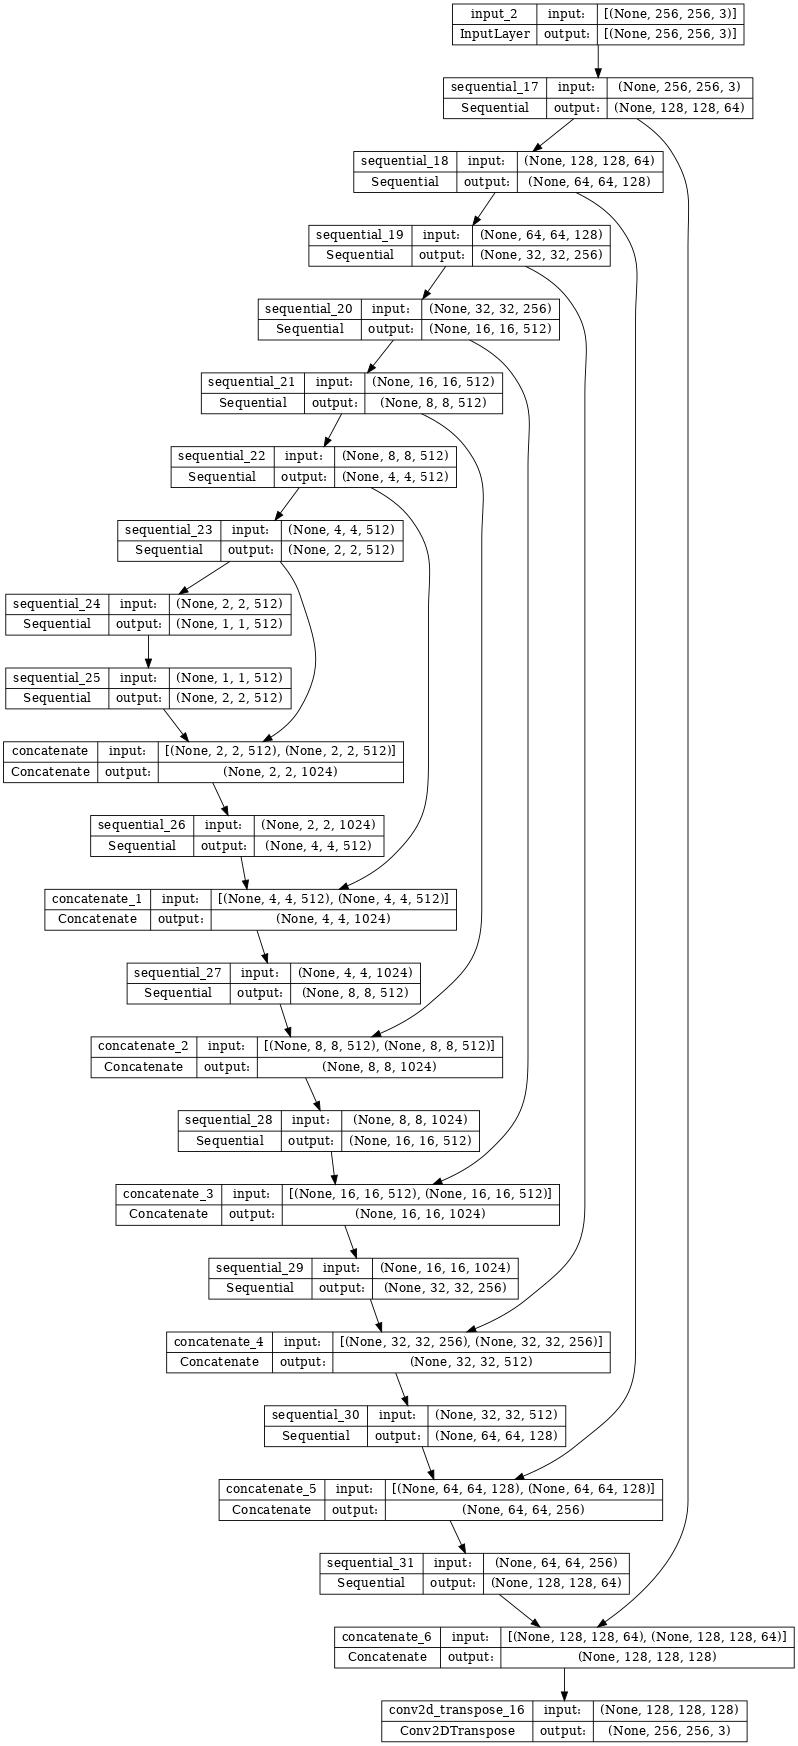

```python
generator = Generator_Attention_UNet()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
```

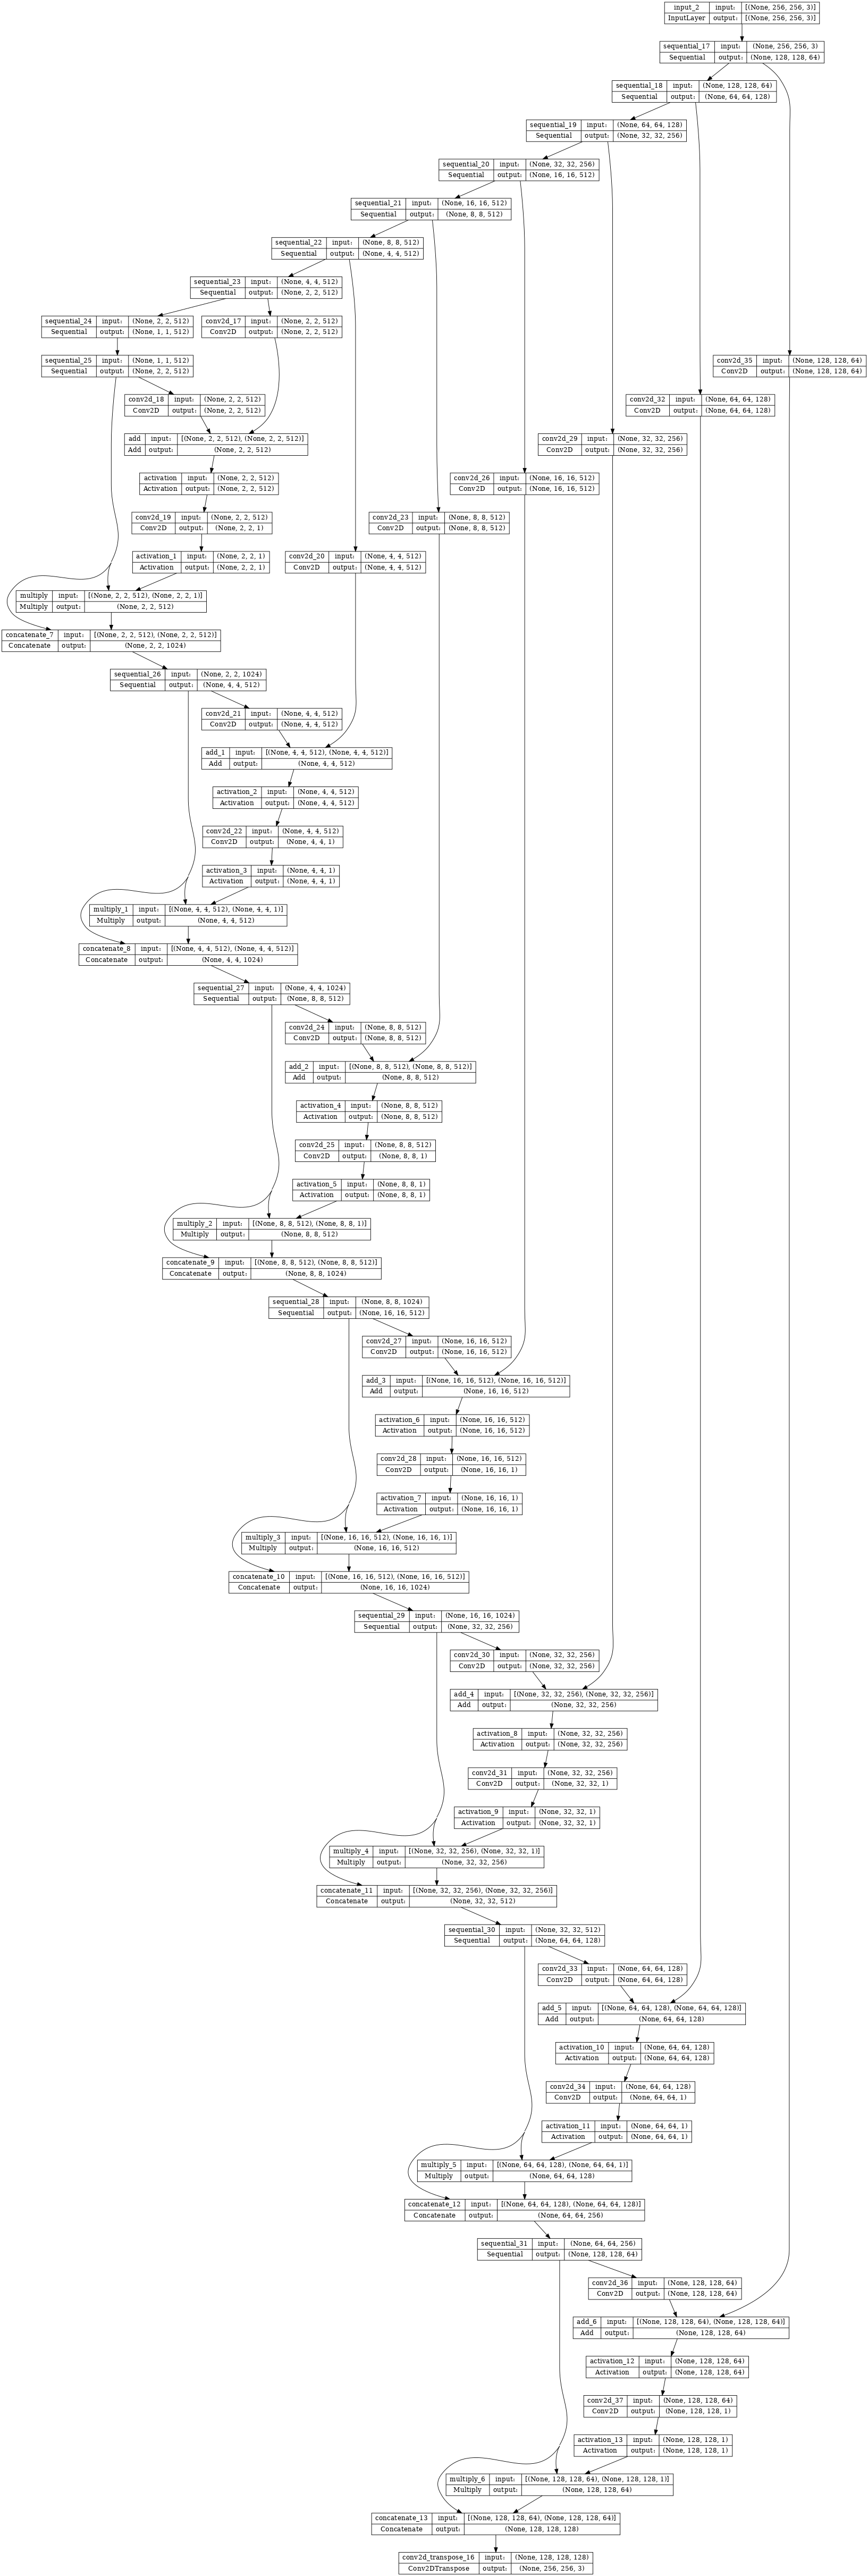

```python
generator = Generator_Attention_Unet_2()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
```

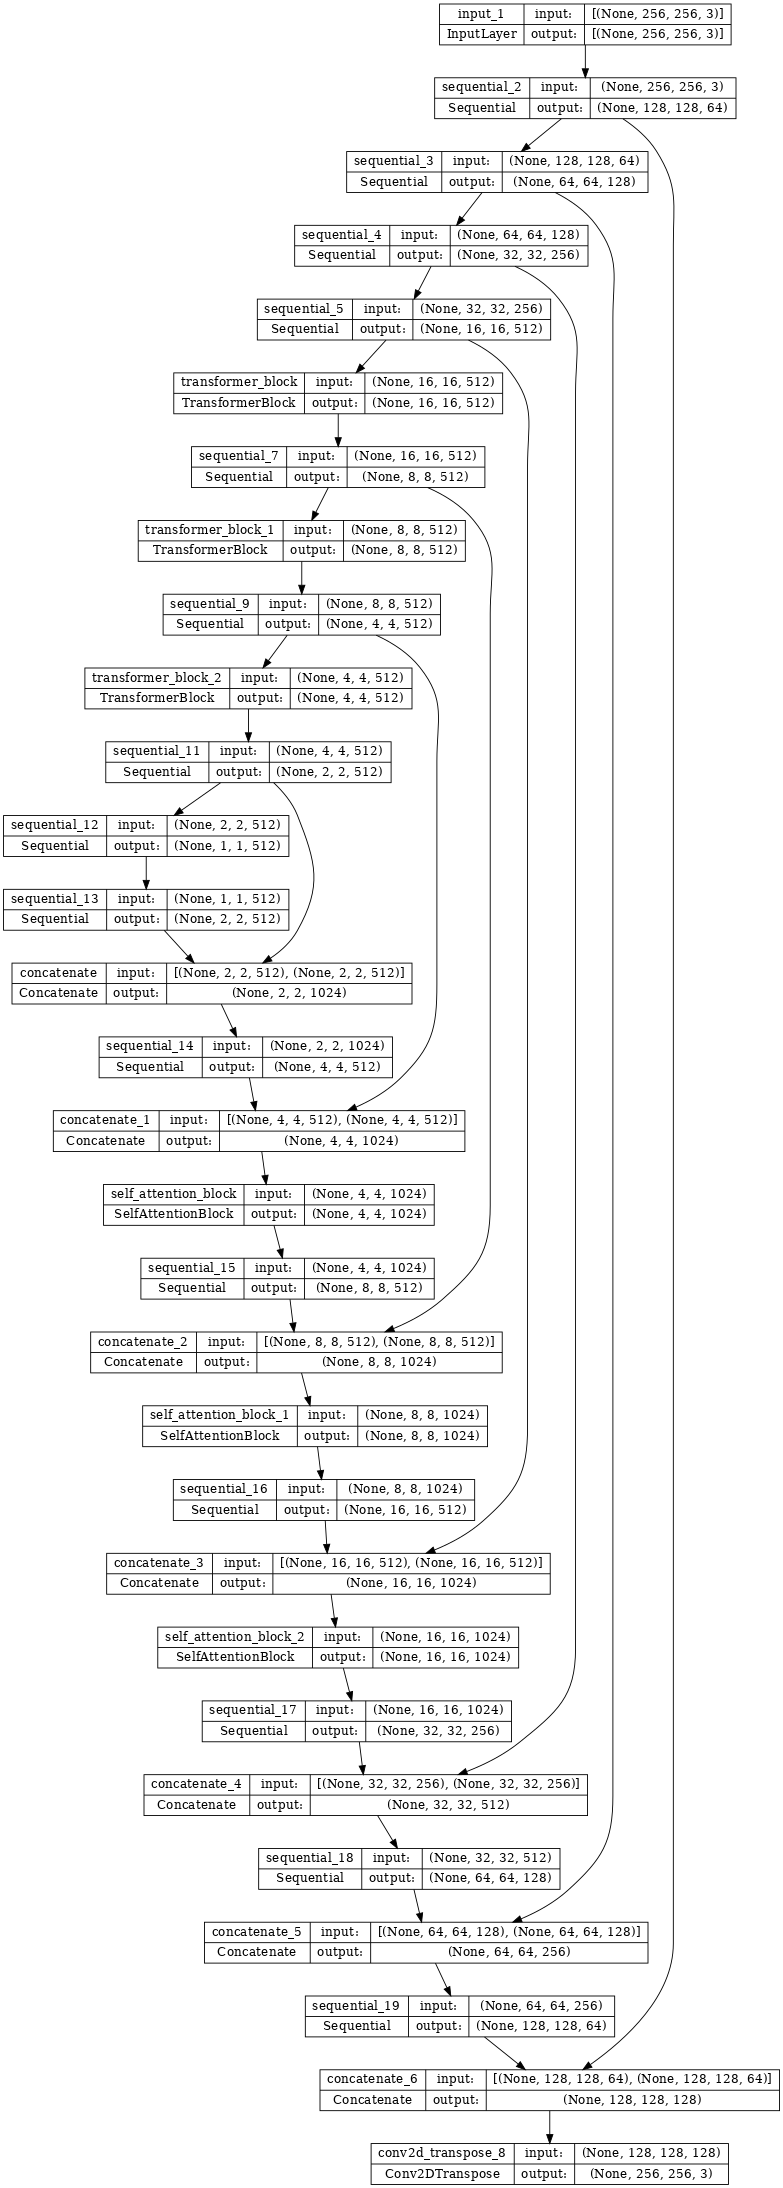

In [324]:
if GENERATOR_NAME == "enc_dec":
    generator = Generator_Enc_Dec()
elif GENERATOR_NAME == "unet":
    generator = Generator_Unet()
elif GENERATOR_NAME == "attention_1":
    generator = Generator_Attention_UNet()
elif GENERATOR_NAME == "attention_2":
    generator = Generator_Attention_UNet_2()

Test the generator:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


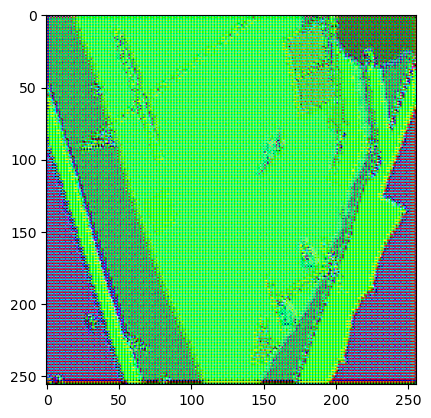

In [325]:
gen_output = generator(rj_inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [326]:
LAMBDA = 100

In [327]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [328]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

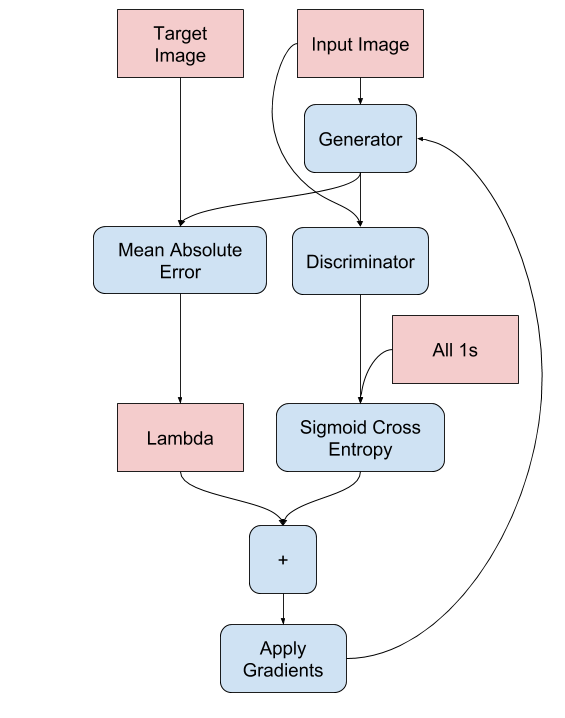

## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [329]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

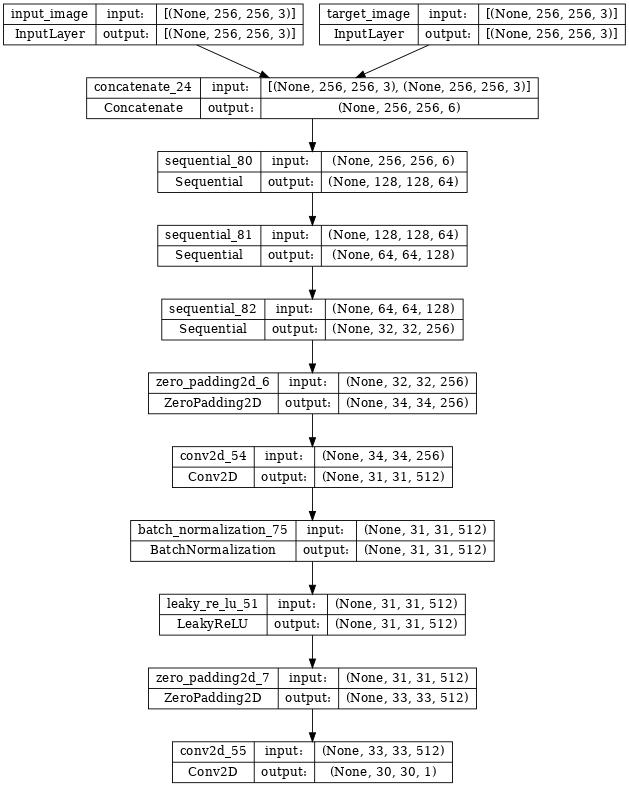

In [330]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

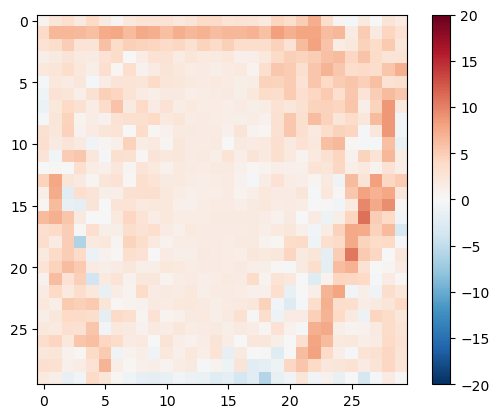

In [331]:
disc_out = discriminator([rj_inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [332]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

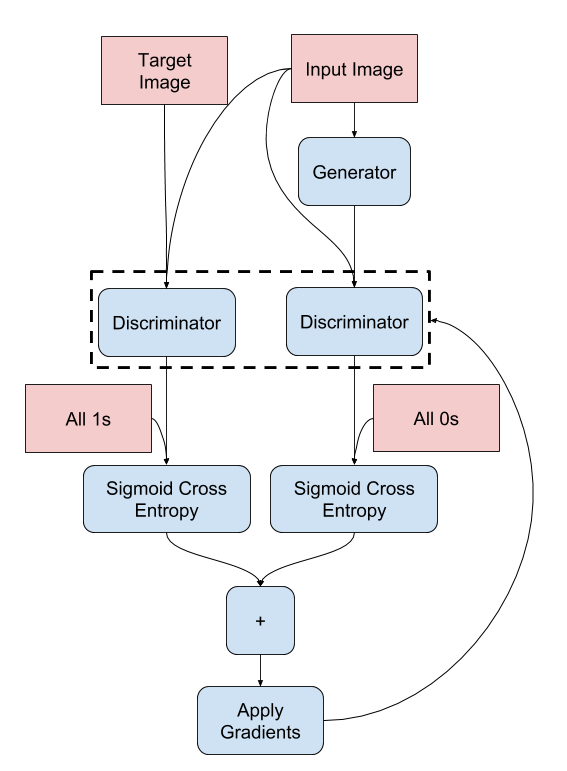

## Define the optimizers and a checkpoint-saver

In [333]:
if OPTIMIZER == "adam":
    generator_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
else:
    generator_optimizer = tf.keras.optimizers.SGD(LR)
    discriminator_optimizer = tf.keras.optimizers.SGD(LR)

In [334]:
checkpoint_dir = './training_checkpoints/'+GENERATOR_NAME+"_"+OPTIMIZER
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If `training=False` is used, we obtain the accumulated statistics learned from the training dataset (which we don't want).

In [335]:
def generate_images(model, test_input, tar, plot=True):
  prediction = model(test_input, training=True)
  
  if(plot):
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

  return prediction

Test the function:

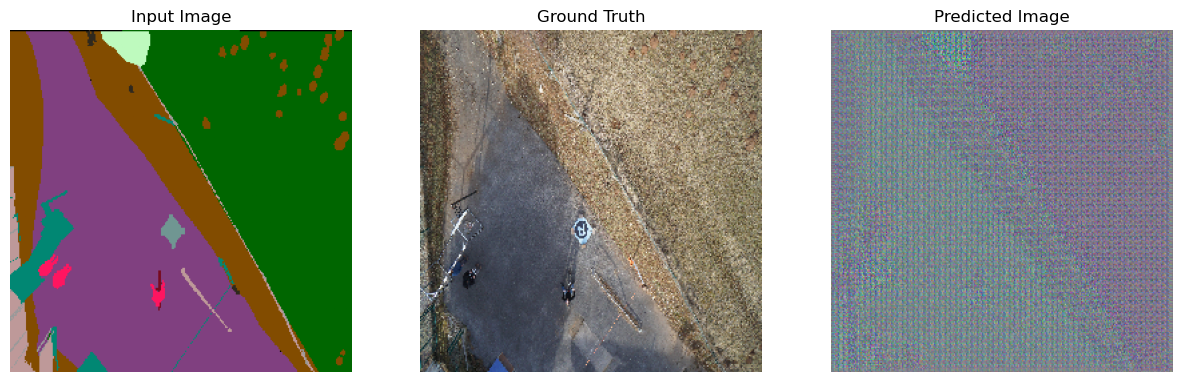

In [336]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [337]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/"+GENERATOR_NAME+"_"+OPTIMIZER + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [338]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    # Calculate SSIM and PSNR
    ssim = tf.image.ssim(target, gen_output, max_val=1.0)
    psnr = tf.image.psnr(target, gen_output, max_val=1.0)
    ssim = tf.reduce_mean(ssim)
    psnr = tf.reduce_mean(psnr)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)


  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
    tf.summary.scalar('ssim', ssim, step=step//1000)
    tf.summary.scalar('psnr', psnr, step=step//1000)

def validate(val_ds, step):
    ssim_values = []
    psnr_values = []
    val_gen_total_loss = 0
    val_gen_l1_loss = 0

    for input_image, target in val_ds:
        gen_output = generator(input_image, training=True)

        # Calculate SSIM and PSNR
        ssim = tf.image.ssim(target, gen_output, max_val=1.0)
        psnr = tf.image.psnr(target, gen_output, max_val=1.0)
        ssim_values.append(ssim)
        psnr_values.append(psnr)

        # Calculate loss
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, _, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        val_gen_total_loss += gen_total_loss
        val_gen_l1_loss += gen_l1_loss

    # Calculate average SSIM and PSNR
    avg_ssim = tf.reduce_mean(ssim_values)
    avg_psnr = tf.reduce_mean(psnr_values)
    val_gen_total_loss = val_gen_total_loss / len(val_ds)
    val_gen_l1_loss = val_gen_l1_loss / len(val_ds)

    # Log the validation metrics
    with summary_writer.as_default():
        tf.summary.scalar('val_gen_total_loss', val_gen_total_loss, step=step//1000)
        tf.summary.scalar('val_gen_l1_loss', val_gen_l1_loss, step=step//1000)
        tf.summary.scalar('val_ssim', avg_ssim, step=step//1000)
        tf.summary.scalar('val_psnr', avg_psnr, step=step//1000)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [339]:
def fit(train_ds, val_ds, steps):
  example_input, example_target = next(iter(val_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      prediction = generate_images(generator, example_input, example_target)
      
      if (step) % 5000 == 0:
        # Show image
        plt.imshow(prediction[0] * 0.5 + 0.5)

      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    # Validation step
    if (step + 1) % 1000 == 0:
        validate(val_ds, step)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

Launch the TensorBoard viewer:

In [340]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12903), started 1:58:11 ago. (Use '!kill 12903' to kill it.)

Finally, run the training loop:

Time taken for 1000 steps: 240.40 sec



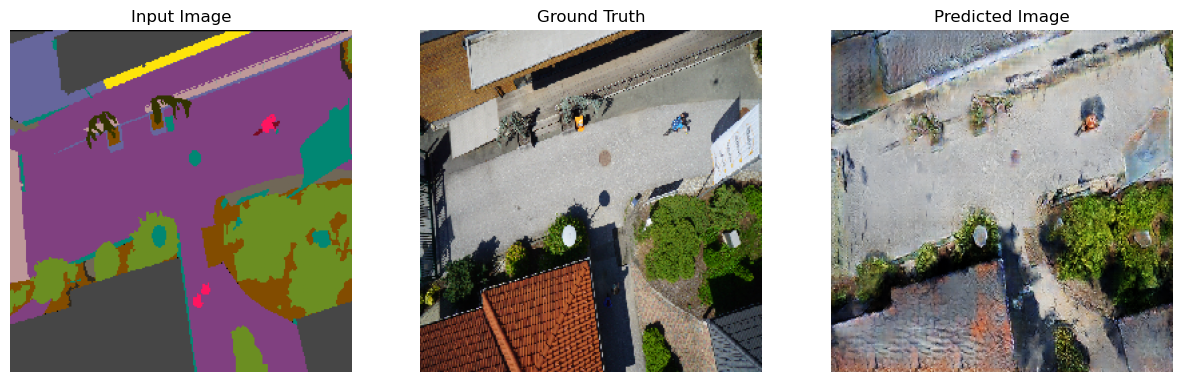

Step: 30k
...............

KeyboardInterrupt: 

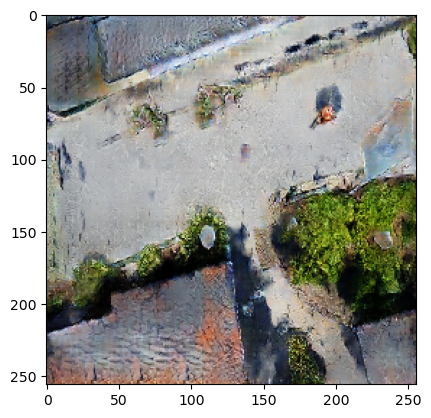

In [341]:
fit(train_dataset, val_dataset, steps=100000)

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [46]:
!ls {checkpoint_dir}

checkpoint		    ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index		    ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index		    ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index		    ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [343]:
checkpoint_dir = './training_checkpoints/'+GENERATOR_NAME+"_"+OPTIMIZER

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

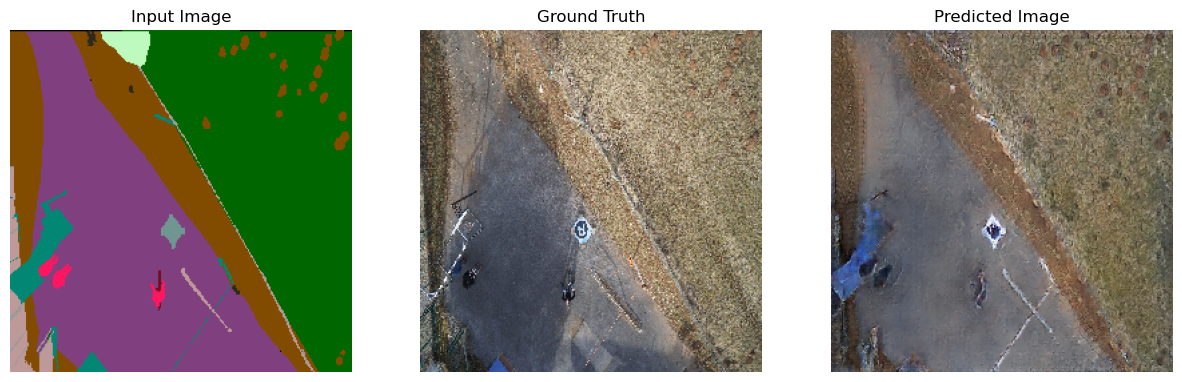

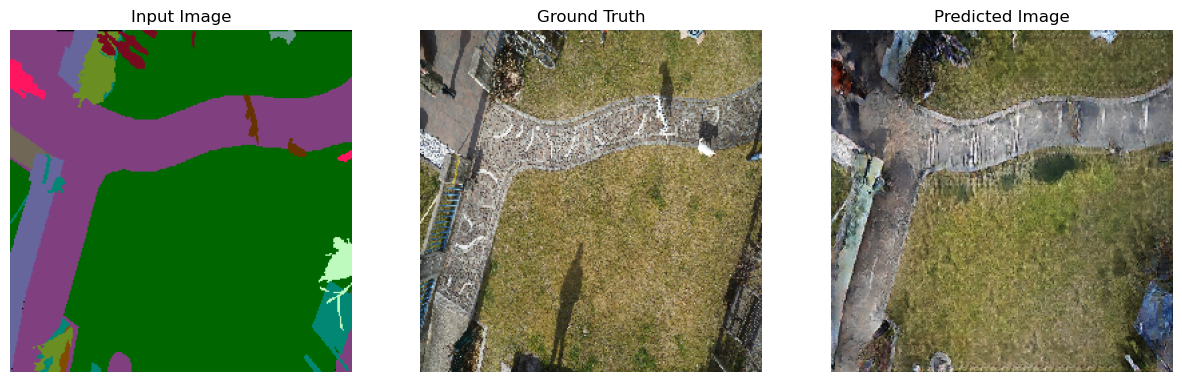

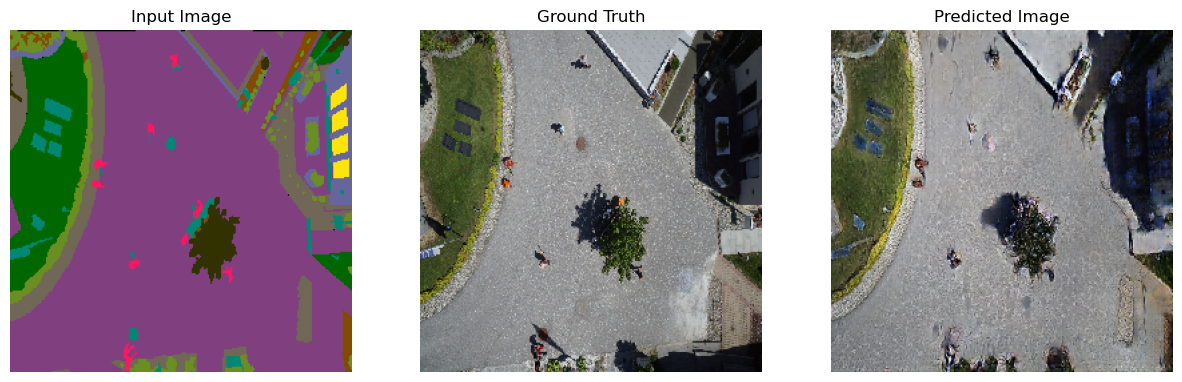

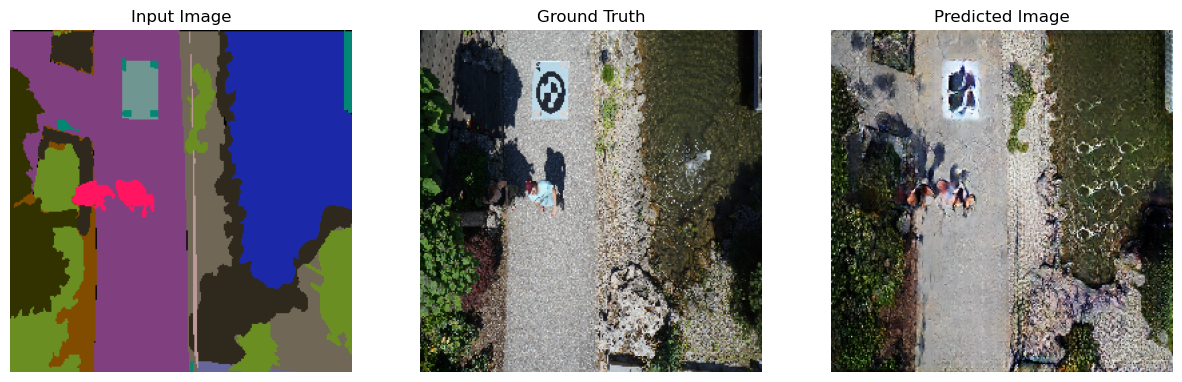

In [245]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

## Generate and save files for evaluation

In order to maintain correlation with the metrics obtained during training we maintain the image output shape of 256x256 instead of applying a posprocessing step to convert the output images to their original shape (400x600).

In [344]:
def posprocess_output(output_image):
   output_image = resize(output_image, 400, 600, method=tf.image.ResizeMethod.BICUBIC)

   return output_image

def generate_and_save_images(model, test_ds):
   # Create folder if they do not exist
   dir = f"{EVAL_FOLDER}/{GENERATOR_NAME}"
   if not os.path.exists(dir):
      os.makedirs(dir+"/outputs")
      os.makedirs(dir+"/gt")
      os.makedirs(dir+"/label")

   # Notice `training` is set to False.
   # This is so all layers run in inference mode (batchnorm).
   for i, (input, target) in test_ds.enumerate():
      predictions = model(input, training=True)
      
      for j in range(len(predictions)):
         #output_image = posprocess_output(predictions[j])
         #real_image = posprocess_output(target[j])
         #input_image = posprocess_output(input[j])
         output_image = predictions[j]
         real_image = target[j]
         input_image = input[j]

         tf.keras.utils.save_img(f'{dir}/outputs/{i+j}.png', output_image, data_format=None, file_format=None, scale=True)
         tf.keras.utils.save_img(f'{dir}/gt/{i+j}.png', real_image, data_format=None, file_format=None, scale=True)
         tf.keras.utils.save_img(f'{dir}/label/{i+j}.png', input_image, data_format=None, file_format=None, scale=True)


In [345]:
# Run the trained model on the test set
generate_and_save_images(generator, test_dataset)

2024-05-10 20:02:55.495950: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


---

## Model evaluation

### Prepare data for evaluation

In [7]:
def load_image_test(image, type=tf.float32):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image)

  # Convert both images to float32 tensors
  image = tf.cast(image, type)

  return image

def convert_to_one_hot(image):
    # Create a "color reference" tensor from image_colors
    color_reference = tf.cast(tf.constant(COLORS), dtype=tf.float32)
    comp = tf.equal(image[..., None, :], color_reference)
    one_hot = tf.cast(tf.reduce_all(comp, axis=-1), dtype=tf.float32)

    return one_hot

def load_label_images(image):
  image = load_image_test(image)
  image = convert_to_one_hot(image)

  return image

### Similarity analysis functions

- **Cosine Similarity-based Feature Comparison**: Involves extracting high-level features from both generated images and ground truth images using a VGG16 pretrained model. Subsequently, the cosine similarity metric is employed to compare these feature vectors. A higher cosine similarity value suggests a closer resemblance between the features extracted from the generated and ground truth images, indicating a higher level of visual similarity.

In [8]:
vgg_model = VGG16(weights='imagenet', include_top=False)

def extract_features(model, image_data):
    preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image_data)
    features = model.predict(preprocessed_image)
    return features.flatten()

def cosine_similarity(x, y):
    dot_product = tf.reduce_sum(tf.multiply(x, y))
    x_norm = tf.sqrt(tf.reduce_sum(tf.square(x)))
    y_norm = tf.sqrt(tf.reduce_sum(tf.square(y)))
    similarity = dot_product / (x_norm * y_norm)
    return similarity

### FID functions

(Not used because there are the authors of the metric recommend using a minimum sample size of 10,000 to calculate the FID, otherwise the true FID of the generator is underestimated)

In [99]:
# load inception v3 model
#model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [112]:
# calculate frechet inception distance
#def calculate_fid(model, img1, img2):

  # calculate activations
#  act1 = model.predict(img1)
#  act2 = model.predict(img2)
  # calculate mean and covariance statistics
#  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
#  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  # calculate sum squared difference between means
#  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
#  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
#  if np.iscomplexobj(covmean):
#    covmean = covmean.real
  # calculate score
#  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
#  print(fid)
#  return fid

#def preprocess_fid(image):
  # Read and decode an image file to a uint8 tensor
#  image = load_test(image)

  # convert integer to floating point values
#  image = tf.cast(image, tf.float32)
  
  # resize images
#  image = resize(image, 299,299)
	
  # Inception preprocessing
#  image = keras.applications.inception_v3.preprocess_input(image)

#  return image

### Quantitative measures (SSIM,PSNR) functions

- **Peak signal-to-noise ratio** (PSNR): Measures the peak signal-to-noise ratio between two monochrome images *I* and *K* to assess the quality of a generated image compared to its corresponding real image. The higher the PSNR (in db), the better quality of the generated image.

- **Structural similarity index** (SSIM): well-characterized perceptual similarity measure that aims to discount aspects of an image that are not important for human perception. It compares corresponding pixels and their neighborhoods in two images, denoted by *x* and *y*, using three quantities—luminance (*I*), contrast (*C*), and structure (*S*)

In [9]:
# Evaluate the trained model on the test set
def compute_metrics(output, ground_truth):
  # Add an outer batch for each image.
  #output = tf.expand_dims(output, axis=0)
  #ground_truth = tf.expand_dims(ground_truth, axis=0)

  # 11x11 Gaussian filter of width 1.5 is used.
  # k1 = 0.01, k2 = 0.03 as in the original paper.
  ssim = tf.image.ssim(output, ground_truth, max_val=255,
                       filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

  psnr = tf.image.psnr(output, ground_truth, max_val=255)

  return ssim, psnr

### Apply metrics

1. Compute SSIM, PSNR, Cosine similarity

In [32]:
output_files = tf.data.Dataset.list_files(f"{EVAL_FOLDER}/{GENERATOR_NAME}/outputs/*.png", shuffle=False)
target_files = tf.data.Dataset.list_files(f"{EVAL_FOLDER}/{GENERATOR_NAME}/gt/*.png", shuffle=False)
label_files = tf.data.Dataset.list_files(f"{EVAL_FOLDER}/{GENERATOR_NAME}/label/*.png", shuffle=False)

BATCH_SIZE = 16

In [34]:
# Run the trained model on the test set
psnr_values = []
ssim_values = []
cos_sim_values = []

# Compute metrics
output_images = output_files.map(load_image_test).batch(BATCH_SIZE)
target_images = target_files.map(load_image_test).batch(BATCH_SIZE)

for output, target in zip(output_images,target_images):
  ssim, psnr = compute_metrics(output, target)

  cos_sim = cosine_similarity(extract_features(vgg_model, output), extract_features(vgg_model, target))
  
  psnr_values.append(psnr)
  ssim_values.append(ssim)
  cos_sim_values.append(cos_sim)
  
psnr = tf.reduce_mean(psnr_values).numpy()
ssim = tf.reduce_mean(ssim_values).numpy()
cos_sim = tf.reduce_mean(cos_sim_values).numpy()

print(f"{ssim=:0.4f}")
print(f"{psnr=:0.4f}")
print(f"{cos_sim=:0.4f}")

1/1 [==============================] - 0s 18ms/step
ssim=0.1447
psnr=12.9243
cos_sim=0.1548


2. Compute FID

In [ ]:
# Compute FID (not images enough)
#output_images = output_files.map(preprocess_fid).batch(BATCH_SIZE)
#target_images = target_files.map(preprocess_fid).batch(BATCH_SIZE)
#fid = calculate_fid(model, output_images,target_images)

#print(f"{fid=}")

3. Compute FCN-score

In [13]:
# Load segmentation model
model_name = 'TU-Graz_fcn8s'
model_dir = os.path.join('models', model_name)
seg_model = keras.models.load_model(os.path.join(model_dir, f"{model_name}.keras"), safe_mode=False)

In [35]:
# Compute histogram
acc_values = []
iou_values = []

# Compute metrics
output_images = output_files.map(load_image_test).batch(BATCH_SIZE)
target_images = target_files.map(load_image_test).batch(BATCH_SIZE)
label_images = label_files.map(load_label_images).batch(BATCH_SIZE)

for output, target, label in zip(output_images,target_images,label_images):
  # Segment images
  output = seg_model(output)
  target = seg_model(target)
  
  # Compute predicted class labels (to categorical labels)
  output = np.argmax(output, axis=-1)
  target = np.argmax(target, axis=-1)
  label = np.argmax(label, axis=-1)

  # Compute accuracy
  acc_values.append(np.sum(output == target)/np.prod(target.shape))

  # Compute Intersection over Union (IoU)
  for class_label in range(NUM_CLASSES):
      # Get masks
      pred_mask = output == class_label
      gt_mask = target == class_label

      # Compute intersection and union
      intersection = np.logical_and(pred_mask, gt_mask).sum()
      union = np.logical_or(pred_mask, gt_mask).sum()
      iou_values.append(intersection / union)
  
acc = tf.reduce_mean(acc_values).numpy()
iou = tf.reduce_mean(iou_values).numpy()

print(f"{acc=:0.4f}")
print(f"{iou=:0.4f}")

acc=0.1938
iou=0.0617


---
## Image grid creation

In [346]:
from PIL import Image, ImageDraw, ImageFont
import os

# Function to load images from directory
def load_images_from_dir(directory):
    images = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            images.append(img)
    return images

# Function to create grid image
def create_grid_image(models_dir, output_dir):
    # Load images for each model
    models = sorted(os.listdir(models_dir))
    label_images = [load_images_from_dir(os.path.join(models_dir, model, "label")) for model in models]
    gt_images = [load_images_from_dir(os.path.join(models_dir, model, "gt")) for model in models]
    output_images = [load_images_from_dir(os.path.join(models_dir, model, "outputs")) for model in models]
    
    # Set up grid parameters
    num_models = len(models)
    num_samples = 12 # Only 5 samples
    image_width, image_height = label_images[0][0].size
    label_font = ImageFont.load_default(32)
    
    # Calculate grid dimensions
    grid_width = (num_models + 2) * image_width
    grid_height = num_samples * image_height + 50
    
    # Create a blank grid image
    grid_img = Image.new('RGB', (grid_width, grid_height), color='white')
    draw = ImageDraw.Draw(grid_img)
    
    # Populate grid with images and labels
    for i in range(num_samples):
        
        # Add label image
        grid_img.paste(label_images[0][i], (0, i * image_height))
        
        # Add ground truth image
        grid_img.paste(gt_images[0][i], (image_width * (1), i * image_height))
        
        # Add model outputs
        for j in range(num_models):
            grid_img.paste(output_images[j][i], (image_width * (j + 2), i * image_height))
    

    # Add labels
    draw.text((0,(i+1) * image_height), "Input", fill='black', font=label_font)
    draw.text((image_width, (i+1) * image_height), "Ground Truth", fill='black', font=label_font)
    for j in range(num_models):
        draw.text(((j+2) * image_width, (i+1) * image_height), models[j], fill='black', font=label_font)
    
    # Save the grid image
    grid_img.save(output_dir)

models_dir = EVAL_FOLDER
output_dir = "grid_image.png"
create_grid_image(models_dir, output_dir)